In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display_html
np.random.seed(42)

### Problem1

### a.

In [2]:
train = pd.read_csv('../HW3/hw3-data/ratings_train.csv', header=None)
train.columns = ['user_id', 'movie_id', 'rating']
test = pd.read_csv('../HW3/hw3-data/ratings_test.csv', header=None)
test.columns = ['user_id', 'movie_id', 'rating']
movie = pd.read_fwf('../HW3/hw3-data/movies.txt', header=None, sep='\n')
movie.columns = ['movie_name']
movie.head(10)
print(train.shape)
print(test.shape)
print(movie.shape)

(95000, 3)
(5000, 3)
(1682, 1)


In [3]:
SIGMA = 0.25
D = 10
LAMBDA = 1
N_1 = 943
N_2 = 1682
print("Number of users: ", N_1)
print("Number of movies: ", N_2)


Number of users:  943
Number of movies:  1682


In [4]:
class matrix_factorization:
    def __init__(self, n_1, n_2, d, n_iterations = 100) -> None:
        self.n_1 = n_1
        self.n_2 = n_2
        self.d = d
        self.n_iterations = n_iterations
        self.user = np.random.normal(0, LAMBDA, size = (n_1, self.d)) # n_1 x d
        self.movie = np.random.normal(0, LAMBDA, size = (n_2, self.d)) # n_2 x d


    def init_M(self, X):
        M = np.empty(shape = (self.n_1, self.n_2))
        M.fill(np.nan)
        for index, row in X.iterrows():
            user_id = int(row['user_id']) - 1
            movie_id = int(row['movie_id']) - 1
            M[user_id][movie_id] = row['rating']
        return M
        
    def fit(self, X):
        self.M = self.init_M(X)
        log_likelihood_list = []
        user_temp = self.user.copy()
        movie_temp = self.movie.copy()

        for iter in range(self.n_iterations):
            
            for u in range(self.n_1):
                omega_i = np.where(~np.isnan(self.M[u,:]))[0] # Index of movies rated by u
                if len(omega_i) == 0: # No moive have been rated by u
                    break
                # Number of movie rated by u -> k
                rated_movie = movie_temp[omega_i,:] # k x d
                rating_M = self.M[u, omega_i].reshape(1,-1) # 1 x k
                M_v = rating_M @ rated_movie # 1 x d
                # 1 x d     =  1 x d  @            d x d                      d x k         @   k x d
                self.user[u] = M_v @ np.linalg.inv((LAMBDA*SIGMA*np.eye(D)) + rated_movie.T @ rated_movie)
            user_temp = self.user.copy()

            for m in range(self.n_2):
                omega_i = np.where(~np.isnan(self.M[:,m]))[0] # Index of users rated m
                if len(omega_i) == 0: # No user have rated m
                    break
                # Number of user rated m -> k
                rated_user = user_temp[omega_i,:] # k x d
                rating_M = self.M[omega_i, m].reshape(1,-1) # 1 x k
                M_v = rating_M @ rated_user # 1 x d
                # 1 x d      =  1 x d @            d x d                       d x k        @   k x d
                self.movie[m] = M_v @ np.linalg.inv((LAMBDA*SIGMA*np.eye(D)) + rated_user.T @ rated_user)
            movie_temp = self.movie.copy()
            
            log_likelihood = self.log_likelihood()
            log_likelihood_list.append(log_likelihood)
        return log_likelihood_list

    def log_likelihood(self):
        # n1 x n2 = n1 x n2 - (n1 x d  @ d x n2)
        part1 = self.M - (self.user @ self.movie.T)
        part1 = part1[~np.isnan(part1)]
        loss = (-(1/SIGMA**2)*np.sum(part1**2) 
                - ((LAMBDA/2)*np.linalg.norm(self.user)**2) 
                - ((LAMBDA/2)*np.linalg.norm(self.movie)**2))
        return loss
    
    def predict(self, test):
        self.pred = np.zeros((test.shape[0]))
        for index, row in test.iterrows():
            user_id = int(row['user_id']) - 1
            movie_id = int(row['movie_id']) - 1
            self.pred[index] = self.user[user_id] @ self.movie[movie_id].T
        return self.pred

    def RMSE(self, test):
        pred = self.predict(test)
        rmse = np.sqrt(np.mean((pred - test['rating'].values)**2))
        return rmse
    

In [5]:
result = pd.DataFrame(columns=['Iteration', 'MAP', 'RMSE'])
log_likelihood_list = []
best_ll = -np.Infinity
best_model = None

for i in range(10):
    mf_model = matrix_factorization(N_1, N_2, D, 100)
    log_likelihood = mf_model.fit(train)
    pred = mf_model.predict(test)
    RMSE = mf_model.RMSE(test)
    log_likelihood_list.append(log_likelihood)
    result.loc[i] = [i, log_likelihood[-1], RMSE]
    if log_likelihood[-1] > best_ll:
        best_ll = log_likelihood[-1]
        best_model = mf_model

result.sort_values(by='MAP', ascending=False)
    
    

,Iteration,MAP,RMSE
2,2.0,-747859.168742,1.128829
9,9.0,-749525.211221,1.097454
3,3.0,-750043.635637,1.101077
8,8.0,-750336.198936,1.110782
6,6.0,-750650.044479,1.108276
1,1.0,-750826.606076,1.113968
7,7.0,-751419.038591,1.108773
0,0.0,-751505.331538,1.078799
4,4.0,-751620.483206,1.078152
5,5.0,-752883.784540,1.096323


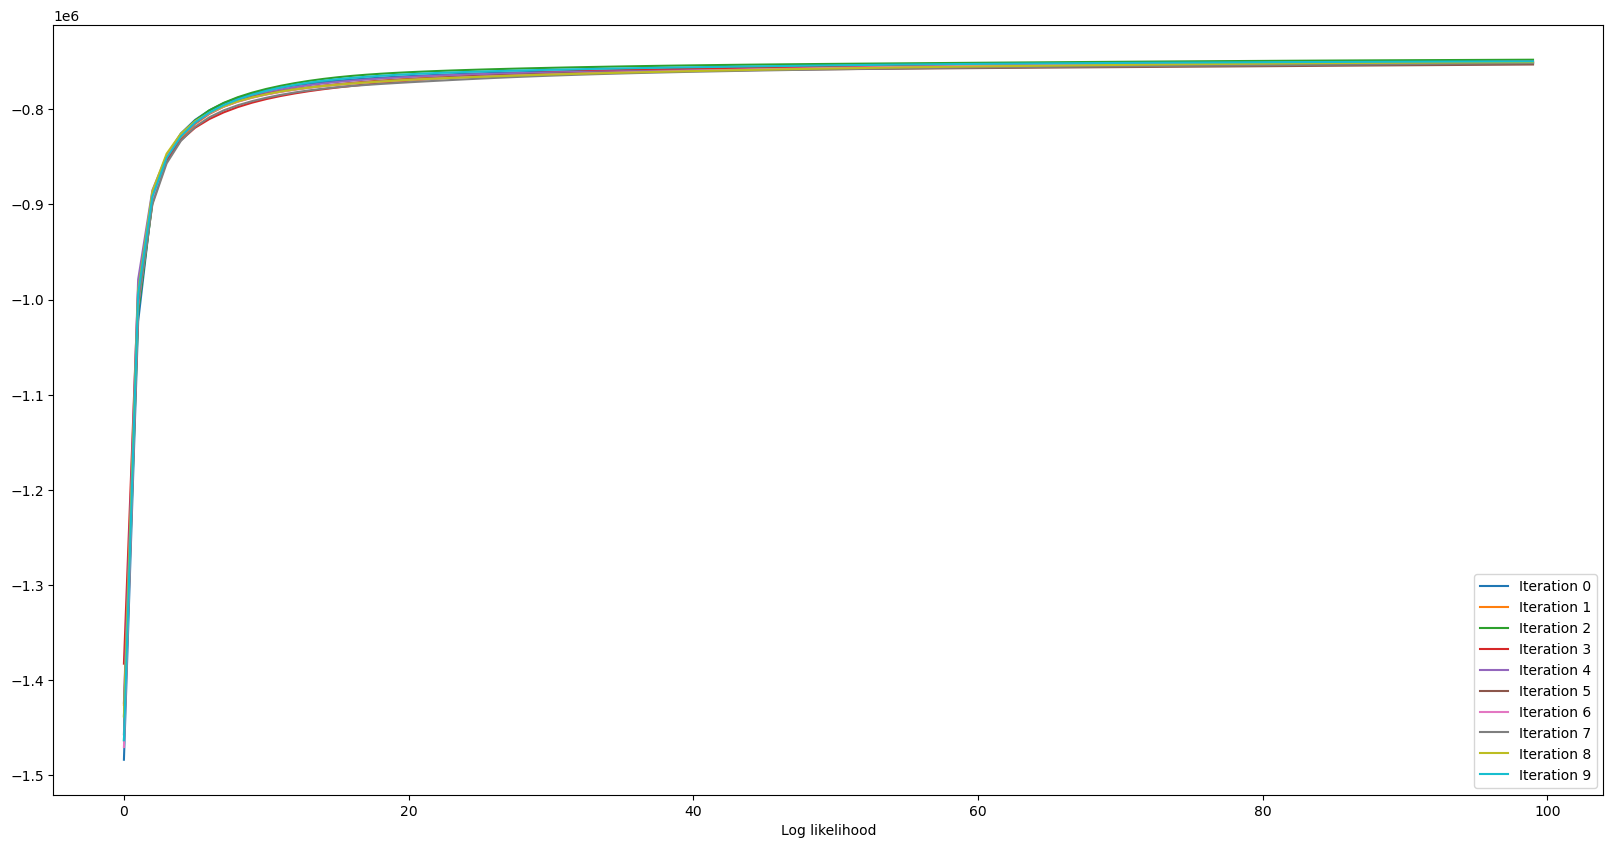

In [6]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(log_likelihood_list[i], label = 'Iteration {}'.format(i))
plt.legend()
plt.xlabel('Iteration')
plt.xlabel('Log likelihood')
plt.show()

### b.

In [7]:
movie_temp = best_model.movie
user_temp = best_model.user

In [8]:
def get_top10(movie_name, movie_matrix, movie):
    movie_index = movie[movie['movie_name'].str.contains(movie_name)].index[0]
    moive_vector = movie_matrix[movie_index] # 1 x d
    movie_df = pd.DataFrame(columns=['moive_name', 'distance'])
    for i in range(movie_matrix.shape[0]):
        distance = np.linalg.norm(moive_vector - movie_matrix[i])
        movie_df.loc[i] = [movie.iloc[i][0], distance]

    movie_df.sort_values(by='distance', ascending=True, inplace=True)

    movie_df = movie_df.iloc[1:]

    return movie_df.head(10)

In [9]:
get_top10('Star Wars', movie_temp, movie)

,moive_name,distance
171,"Empire Strikes Back, The (1980)",0.380104
173,Raiders of the Lost Ark (1981),0.614647
180,Return of the Jedi (1983),0.835706
193,"Sting, The (1973)",0.888138
198,"Bridge on the River Kwai, The (1957)",0.977276
63,"Shawshank Redemption, The (1994)",1.066094
209,Indiana Jones and the Last Crusade (1989),1.086239
519,"Great Escape, The (1963)",1.106433
1188,Prefontaine (1997),1.110900
175,Aliens (1986),1.113176


In [10]:
get_top10('My Fair Lady', movie_temp, movie)

,moive_name,distance
418,Mary Poppins (1964),1.006996
739,Jane Eyre (1996),1.039855
142,"Sound of Music, The (1965)",1.048720
450,Grease (1978),1.073920
274,Sense and Sensibility (1995),1.121201
282,Emma (1996),1.121766
704,Singin' in the Rain (1952),1.210452
628,Victor/Victoria (1982),1.218568
601,"American in Paris, An (1951)",1.256800
1146,My Family (1995),1.267139


In [11]:
get_top10('GoodFellas', movie_temp, movie)

,moive_name,distance
503,Bonnie and Clyde (1967),0.751470
199,"Shining, The (1980)",0.815122
176,"Good, The Bad and The Ugly, The (1966)",0.830389
645,Once Upon a Time in the West (1969),0.865401
187,Full Metal Jacket (1987),0.910824
692,Casino (1995),0.940235
186,"Godfather: Part II, The (1974)",0.973353
149,Swingers (1996),1.003256
237,Raising Arizona (1987),1.019529
179,Apocalypse Now (1979),1.026744


### Problem2

### a.

In [12]:
nyt_vocab = pd.read_csv('./hw3-data/nyt_vocab.dat', header=None)
nyt_vocab.shape

(3012, 1)

In [13]:
with open('./hw3-data/nyt_data.txt', 'r', encoding='utf-8-sig') as f:
    nyt_data = f.read().splitlines()

In [14]:
X_matrix = np.zeros((nyt_vocab.shape[0], len(nyt_data)))

for i in range(len(nyt_data)):
    for word in nyt_data[i].split(','):
        X_matrix[int(word.split(':')[0])-1, i] = int(word.split(':')[1])
X_matrix.shape

(3012, 8447)

In [15]:
SIGMA = 0.25
D = 25
LAMBDA = 1
N_1 = 3012
N_2 = 8447
EPSILON = 1e-16
print("Number of words: ", N_1)
print("Number of documents: ", N_2)
print('Number of topics: ', D)

Number of words:  3012
Number of documents:  8447
Number of topics:  25


In [16]:
class NMF:
    def __init__(self, n_1, n_2, d, n_iterations = 100) -> None:
        self.n_1 = n_1
        self.n_2 = n_2
        self.d = d
        self.n_iterations = n_iterations
        self.word = np.random.uniform(1, 2, size = (n_1, self.d)) # n1 x d
        self.doc = np.random.uniform(1, 2, size = (n_2, self.d)) # n2 x d

    def fit(self, X_matrix):
        div_list = []
        for _ in range(self.n_iterations):
            doc_temp = self.doc
            word_temp = self.word
            #     n_1 x d   @  d x n_2
            self.WH = (self.word @ self.doc.T)
            # n2 x d =   n2 x d  *       n2 x n1    @ n1 x d    / 1 x d
            self.doc = self.doc * ((X_matrix/(self.WH+EPSILON)).T @ self.word)/(np.sum(self.word, 0).reshape(1,-1) + EPSILON)
            
            self.WH = (self.word @ self.doc.T)
            # n1 x d  = n1 x d  *       n1 x n2    @ n2 x d    / 1 x d
            self.word = self.word * (X_matrix/(self.WH+EPSILON) @ self.doc)/(np.sum(self.doc, 0).reshape(1,-1) + EPSILON)

            self.WH = (self.word @ self.doc.T)
            div = self.divergence(X_matrix)
            div_list.append(div)


        return div_list
    
    def divergence(self, X_matrix):
        return np.sum(X_matrix * np.log(1/(self.WH+EPSILON)) + self.WH)


In [17]:
NMF_model = NMF(N_1, N_2, D, 100)
div_list = NMF_model.fit(X_matrix)

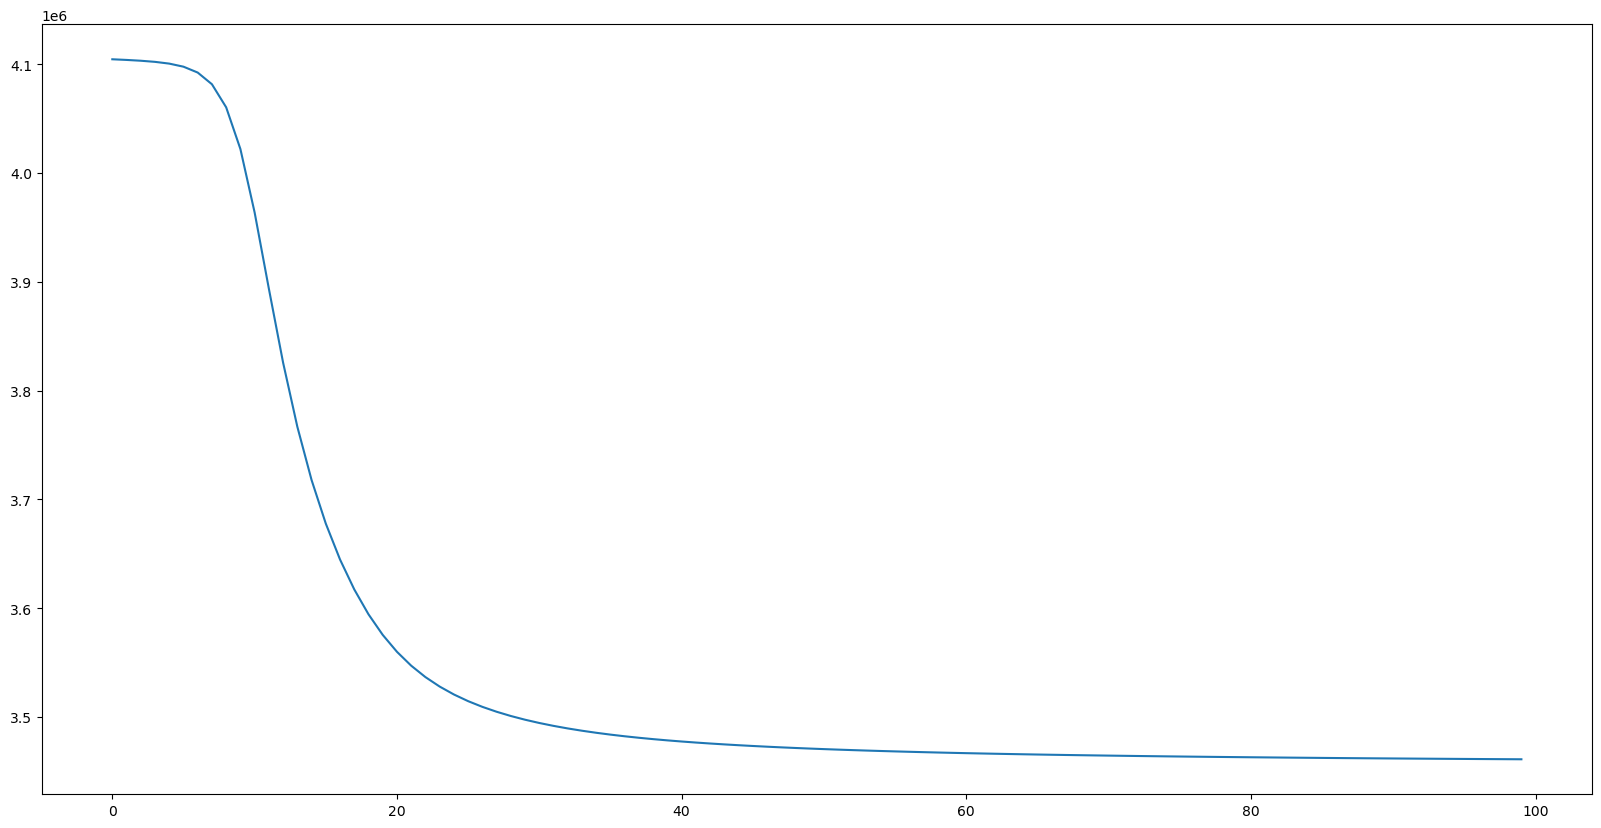

In [18]:
fig = plt.figure(figsize=(20,10))
plt.plot(div_list)
plt.show()

### b.

In [19]:
word_matrix = NMF_model.word
doc_matrix = NMF_model.doc
a = np.sum(word_matrix, 0).reshape(1,-1)
word_matrix = word_matrix/a
doc_matrix = doc_matrix/a


In [20]:
index_10 = np.argsort(word_matrix[:,0])[-10:]
nyt_vocab.iloc[index_10, 0]

781          jury
904      sentence
722    prosecutor
629        prison
404         trial
313         judge
126         court
88         charge
17           case
162        lawyer
Name: 0, dtype: object

In [21]:
np.sort(word_matrix[:,0])[-10:]

array([0.01108162, 0.01241141, 0.01323069, 0.01452332, 0.01884029,
       0.0200721 , 0.02204141, 0.02243564, 0.02340274, 0.02973186])

In [22]:
test_result = pd.DataFrame(columns = ['topic', 'word', 'weight'])
test_result['word'] = nyt_vocab.iloc[index_10, 0]
test_result['weight'] = np.sort(word_matrix[:,0])[-10:]
test_result['topic'] = 'topic{}'.format(0)
test_result

,topic,word,weight
781,topic0,jury,0.011082
904,topic0,sentence,0.012411
722,topic0,prosecutor,0.013231
629,topic0,prison,0.014523
404,topic0,trial,0.018840
313,topic0,judge,0.020072
126,topic0,court,0.022041
88,topic0,charge,0.022436
17,topic0,case,0.023403
162,topic0,lawyer,0.029732


In [23]:
result = np.empty((5,5), dtype=object)
for i in range(5):
    for j in range(5):
        current_index = i*5+j
        result_temp = pd.DataFrame(columns = ['topic', 'word', 'weight'])
        index_10 = np.argsort(word_matrix[:,current_index])[-10:]
        result_temp['word'] = nyt_vocab.iloc[index_10, 0]
        result_temp['weight'] = np.sort(word_matrix[:,current_index])[-10:]
        result_temp['topic'] = 'topic{}'.format(current_index)
        result[i,j] = result_temp

In [27]:
for i in range(5):
    df1, df2, df3, df4, df5 = result[i][0], result[i][1], result[i][2], result[i][3], result[i][4]
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Topic{}'.format(i*5 + 0))
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Topic{}'.format(i*5 + 1))
    df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('Topic{}'.format(i*5 + 2))
    df4_styler = df4.style.set_table_attributes("style='display:inline'").set_caption('Topic{}'.format(i*5 + 3))
    df5_styler = df5.style.set_table_attributes("style='display:inline'").set_caption('Topic{}'.format(i*5 + 4))
    display_html(df1_styler._repr_html_()
             +df2_styler._repr_html_()
             +df3_styler._repr_html_()
             +df4_styler._repr_html_()
             +df5_styler._repr_html_()
             , raw=True)

,topic,word,weight
781,topic0,jury,0.011082
904,topic0,sentence,0.012411
722,topic0,prosecutor,0.013231
629,topic0,prison,0.014523
404,topic0,trial,0.018840
313,topic0,judge,0.020072
126,topic0,court,0.022041
88,topic0,charge,0.022436
17,topic0,case,0.023403
162,topic0,lawyer,0.029732


,topic,word,weight
252,topic5,mother,0.013809
72,topic5,live,0.014344
380,topic5,wife,0.015121
177,topic5,friend,0.015873
6,topic5,man,0.017564
115,topic5,young,0.018791
21,topic5,life,0.022939
44,topic5,family,0.025591
20,topic5,child,0.028500
19,topic5,woman,0.028825


,topic,word,weight
16,topic10,home,0.009262
200,topic10,project,0.009488
444,topic10,neighborhood,0.009666
237,topic10,street,0.010324
82,topic10,house,0.012757
102,topic10,area,0.012958
149,topic10,build,0.013152
330,topic10,resident,0.015706
121,topic10,building,0.023201
7,topic10,city,0.027036


,topic,word,weight
408,topic15,investment,0.010644
112,topic15,buy,0.010861
36,topic15,business,0.011608
69,topic15,executive,0.011611
79,topic15,sell,0.011845
235,topic15,bank,0.012953
140,topic15,stock,0.013575
320,topic15,financial,0.014358
113,topic15,share,0.016007
0,topic15,company,0.028196


,topic,word,weight
328,topic20,product,0.008662
112,topic20,buy,0.009816
403,topic20,customer,0.010079
212,topic20,store,0.010813
86,topic20,cost,0.011912
79,topic20,sell,0.014748
131,topic20,sale,0.016022
36,topic20,business,0.016120
170,topic20,industry,0.018338
0,topic20,company,0.030475
